<a href="https://colab.research.google.com/github/KilluJ/nlp-projects/blob/main/Rating%20Classifier%20(with%20more%20text%20preprocessing%20less%20overfitting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#preprocess the .json file
import pandas as pd

df = pd.read_json('reviews.json', lines=True)
data = df[["reviewText", "overall"]]

#equally split the train set and the test set
train, test = data[:len(data)//2], data[len(data)//2:]


In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.stem import WordNetLemmatizer

from tensorflow.keras import layers
from tensorflow.keras import losses

#lemmatize and removing stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def lemma_n_stopwords(sentence):
    word_list = nltk.word_tokenize(sentence)
    filtered_sentence = []
    for w in word_list:
        if w not in stop_words:
            filtered_sentence.append(w)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in filtered_sentence])
    return lemmatized_output

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
#make new directory to store .text files for each review under each rating group
train_dir, test_dir = './train', './test'
os.mkdir(train_dir)
os.mkdir(test_dir)

#make new directory for each rating group
for k in set(train["overall"]):
    os.mkdir(os.path.join(train_dir, str(k)))
    os.mkdir(os.path.join(test_dir, str(k)))

#convert each review to a .text file for training set
for index, row in train.iterrows():
    curdir = os.path.join(train_dir, str(row['overall']))
    curname = str(row['overall']) + str(index) + '.txt'
    f = open(os.path.join(curdir, curname), 'w', encoding='utf-8')
    #f.write(row['reviewText'])
    f.write(lemma_n_stopwords(row['reviewText']))
    f.close()

#convert each review to a .text file for testing set
for index, row in test.iterrows():
    curdir = os.path.join(test_dir, str(row['overall']))
    curname = str(row['overall']) + str(index) + '.txt'
    f = open(os.path.join(curdir, curname), 'w', encoding='utf-8')
    #f.write(row['reviewText'])
    f.write(lemma_n_stopwords(row['reviewText']))
    f.close()

In [4]:
#check for a random review rated 1/5
sample_file = os.path.join(train_dir, '1/1100261.txt')
with open(sample_file) as f:
    print(f.read())

Maybe work schrader valve beach ball , utterly useless presta valve . After 30 frustrating minute trying air tube bike , I returned store , bought Giant Control Tower T1 pump local bike shop , I back business .


In [5]:
#preparing input for training set
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 148168 files belonging to 5 classes.
Using 118535 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"It work . I personally like wire brush part separate rope opposed rope cleaner combined ( although I n't ever tried one n't take seriously ) . This thing easy use seems like gentle gun . I used couple time far reliability TBD ( seems like pull cord could separate fat rope cleaner time ) ."
Label 4
Review b'Breathe good comfortable . Im small medium , fit good . Great warm weather . . .'
Label 3
Review b"I purchased X-Large size Small size . I got small one use quick clean ups , towel pat dry face etc , large one showering AND use blanket airplane . I always use airline 's blanket , since started charging may sanitary , I plan use Sea Summit X-Large size one blanket . I love pack away easily . I n't used towel yet , I 'm sure absorbent . But , I love big X-Large one , using blanket , cover entire body showering ."
Label 4


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 148168 files belonging to 5 classes.
Using 29633 files for validation.


In [8]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './test',
    batch_size=batch_size)

Found 148169 files belonging to 5 classes.


In [9]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation),'')

#vectorize the input
max_features = 10000
sequence_length = 250
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [10]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


In [11]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'These target take beating keep going . I shot 9mm , .40 , .45acp , .44mag , 7.62x39 .308 ..... No problem . This good great item , family shoot great way add little fun family time .. wish shell cheaper .. im glad unit sold said . I foresee lot good time future', shape=(), dtype=string)
Label 5
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  93,  221,   67, 2295,   52,  114,    2,  284,  882,  548, 4548,
           1, 5792, 2064,  238,   81,   13,   10,    8,  111,  883,  350,
           8,   61,  302,   20,  489,  883,   19,  325,  520,  547, 1073,
         615,  389, 1056,  253,    2, 7495,   78,   10,   19, 1074,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 

In [12]:
print("2535 ---> ",vectorize_layer.get_vocabulary()[2535])
print("124 ---> ",vectorize_layer.get_vocabulary()[124])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2535 --->  tea
124 --->  hard
Vocabulary size: 10000


In [13]:
#do the final vectorization for each data group
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#define our model
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.5),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 160085 (625.33 KB)
Trainable params: 160085 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [16]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',
              metrics=['accuracy'])

In [17]:
#start training
epochs = 10

checkpoint_filepath = './checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=0)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, earlystop_callback])

Epoch 1/10
3705/3705 [==============================] - 108s 29ms/step - loss: 1.0426 - accuracy: 0.6403 - val_loss: 1.0058 - val_accuracy: 0.6414
Epoch 2/10
3705/3705 [==============================] - 15s 4ms/step - loss: 0.9717 - accuracy: 0.6433 - val_loss: 0.9363 - val_accuracy: 0.6475
Epoch 3/10
3705/3705 [==============================] - 15s 4ms/step - loss: 0.9084 - accuracy: 0.6528 - val_loss: 0.8926 - val_accuracy: 0.6578
Epoch 4/10
3705/3705 [==============================] - 16s 4ms/step - loss: 0.8722 - accuracy: 0.6629 - val_loss: 0.8684 - val_accuracy: 0.6663
Epoch 5/10
3705/3705 [==============================] - 16s 4ms/step - loss: 0.8483 - accuracy: 0.6715 - val_loss: 0.8515 - val_accuracy: 0.6729
Epoch 6/10
3705/3705 [==============================] - 15s 4ms/step - loss: 0.8319 - accuracy: 0.6762 - val_loss: 0.8408 - val_accuracy: 0.6765
Epoch 7/10
3705/3705 [==============================] - 15s 4ms/step - loss: 0.8200 - accuracy: 0.6801 - val_loss: 0.8344 - val_

In [18]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

4631/4631 [==============================] - 17s 4ms/step - loss: 0.8372 - accuracy: 0.6726
Loss:  0.8371558785438538
Accuracy:  0.6725766062736511


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

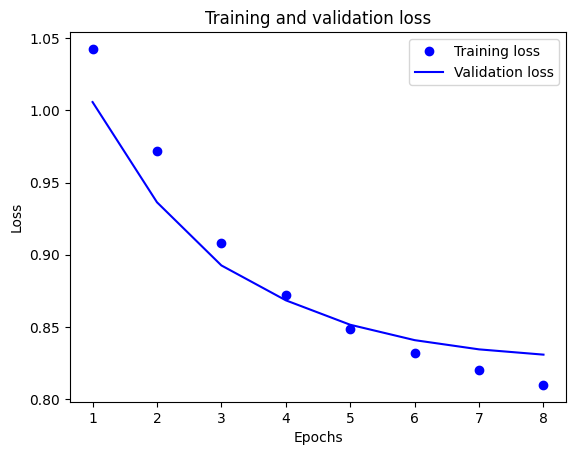

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

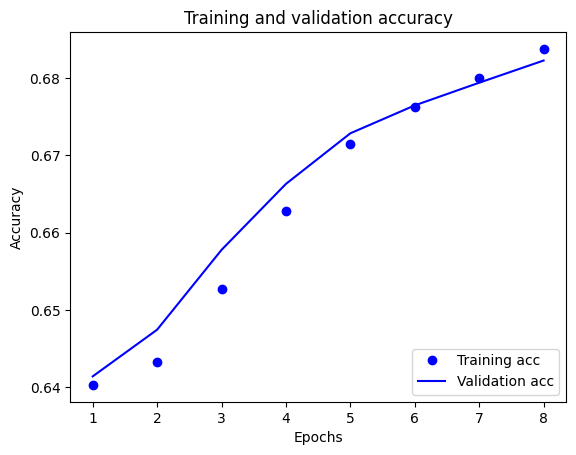

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [22]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

4631/4631 [==============================] - 21s 5ms/step - loss: 1.2975 - accuracy: 0.6726
0.6725766062736511


In [23]:
#the examples are randomwly picked from the 'summary' section of the original .json file
examples = [
  "seems okay.", #3
  "love love love!", #5
  "great for my device", #4
    "perfect.", #5
    "do not waste your money.", #1
    "try it yourself.", #3
]

[int(tf.math.argmax(l)) + 1 for l in export_model.predict(examples)]

1/1 [==============================] - 0s 149ms/step


[5, 5, 5, 5, 1, 5]